## Importando las librerías y módulos a usar

In [1]:
import numpy as np
import sympy as smp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter

## Definiendo los símbolos que vamos a usar con sympy

Definimos los parámetros y constantes.

In [2]:
t, g = smp.symbols('t g')
m1, m2 = smp.symbols('m_1 m_2')
L1, L2 = smp.symbols('L_1 L_2')

Definimos a $\theta_1$ y $\theta_2$ como funciones del tiempo.

In [3]:
the1, the2 = smp.symbols(r'\theta_1 \theta_2', cls=smp.Function)

In [4]:
the1 = the1(t)
the2 = the2(t)

In [5]:
the2

\theta_2(t)

Definimos derivadas primeras y segundas también.

In [6]:
the1_t = smp.diff(the1,t)
the2_t = smp.diff(the2,t)
the1_tt = smp.diff(the1_t,t)
the2_tt = smp.diff(the2_t,t)

In [7]:
the2_tt

Derivative(\theta_2(t), (t, 2))

## Escribimos nuestra transformación de coordenadas

Definimos $x_1$, $y_1$, $x_2$ y $y_2$ en función de los parámetros de arriba.

In [8]:
x1 = L1*smp.sin(the1)
y1 = -L1*smp.cos(the1)
x2 = L1*smp.sin(the1) + L2*smp.sin(the2)
y2 = -L1*smp.cos(the1) - L2*smp.cos(the2)

Definimos las energías cinética y potencial y luego el lagrangiano del sistema.

In [9]:
# Cinética
T1 = smp.Rational(1,2) * m1 * (smp.diff(x1,t)**2 + smp.diff(y1,t)**2)
T2 = smp.Rational(1,2) * m2 * (smp.diff(x2,t)**2 + smp.diff(y2,t)**2)
T = T1 + T2
# Potencial
V1 = m1 * g * y1
V2 = m2 * g * y2
V = V1 + V2
# Lagrangiano
L = T - V

Veamos la forma que toma el lagrangiano y digámosle a SymPy que simplifique lo más que pueda la expresión.

In [10]:
L.simplify()

L_1**2*m_1*Derivative(\theta_1(t), t)**2/2 + L_1*g*m_1*cos(\theta_1(t)) + g*m_2*(L_1*cos(\theta_1(t)) + L_2*cos(\theta_2(t))) + m_2*(L_1**2*Derivative(\theta_1(t), t)**2 + 2*L_1*L_2*cos(\theta_1(t) - \theta_2(t))*Derivative(\theta_1(t), t)*Derivative(\theta_2(t), t) + L_2**2*Derivative(\theta_2(t), t)**2)/2

## Obtenemos las ecuaciones de movimiento

Lo que queremos es resolver estas ecuaciones diferenciales para las funciones de los ángulos, que según E+L me hacen satisfacer
$$
\frac{\partial L}{\partial \theta_1} - \frac{d}{dt}\frac{\partial L}{\partial \dot\theta_1} = 0
$$
$$
\frac{\partial L}{\partial \theta_2} - \frac{d}{dt}\frac{\partial L}{\partial \dot\theta_2} = 0
$$

Para eso lo que hacemos primero es definir los lados izquierdos de las ecuaciones. Después con un método podemos resolver para $\ddot\theta_1$ y $\ddot\theta_2$.

In [15]:
EL1 = smp.diff(L,the1) - smp.diff(smp.diff(L, the1_t), t)
EL2 = smp.diff(L,the2) - smp.diff(smp.diff(L, the2_t), t)

In [23]:
smp.diff(L,the1).simplify().factor(the1_tt,the2_tt, the1_t)

-L_1*(L_2*m_2*sin(\theta_1(t) - \theta_2(t))*Derivative(\theta_1(t), t)*Derivative(\theta_2(t), t) + g*m_1*sin(\theta_1(t)) + g*m_2*sin(\theta_1(t)))

In [24]:
smp.diff(smp.diff(L, the1_t), t).simplify().factor(the1_tt,the2_tt, the1_t)

L_1*(-L_2*m_2*sin(\theta_1(t) - \theta_2(t))*Derivative(\theta_1(t), t)*Derivative(\theta_2(t), t) + L_2*m_2*sin(\theta_1(t) - \theta_2(t))*Derivative(\theta_2(t), t)**2 + L_2*m_2*cos(\theta_1(t) - \theta_2(t))*Derivative(\theta_2(t), (t, 2)) + (L_1*m_1 + L_1*m_2)*Derivative(\theta_1(t), (t, 2)))

In [34]:
smp.diff(L, the1_t).simplify()

L_1*(L_1*m_1*Derivative(\theta_1(t), t) + m_2*(L_1*Derivative(\theta_1(t), t) + L_2*cos(\theta_1(t) - \theta_2(t))*Derivative(\theta_2(t), t)))

In [32]:
smp.diff(m2*L1*L2*smp.cos(the1-the2)*the2_t,t).simplify()

L_1*L_2*m_2*(-(Derivative(\theta_1(t), t) - Derivative(\theta_2(t), t))*sin(\theta_1(t) - \theta_2(t))*Derivative(\theta_2(t), t) + cos(\theta_1(t) - \theta_2(t))*Derivative(\theta_2(t), (t, 2)))

In [18]:
EL1.simplify()#.factor(the1_tt, the2_tt)

-L_1*(L_1*m_1*Derivative(\theta_1(t), (t, 2)) + L_1*m_2*Derivative(\theta_1(t), (t, 2)) + L_2*m_2*sin(\theta_1(t) - \theta_2(t))*Derivative(\theta_2(t), t)**2 + L_2*m_2*cos(\theta_1(t) - \theta_2(t))*Derivative(\theta_2(t), (t, 2)) + g*m_1*sin(\theta_1(t)) + g*m_2*sin(\theta_1(t)))

In [17]:
EL2.simplify()

L_2*m_2*(L_1*sin(\theta_1(t) - \theta_2(t))*Derivative(\theta_1(t), t)**2 - L_1*cos(\theta_1(t) - \theta_2(t))*Derivative(\theta_1(t), (t, 2)) - L_2*Derivative(\theta_2(t), (t, 2)) - g*sin(\theta_2(t)))

In [16]:
sols = smp.solve([EL1, EL2], (the1_tt, the2_tt), simplify=False, rational=False)

In [17]:
sols[the1_tt].simplify() #Con esto vemos la expresión. Con el ; no lo mostramos

(L_1*m_1*sin(2*\theta_1(t) - 2*\theta_2(t))*Derivative(\theta_1(t), t)**2 + 2*L_2*m_1*sin(\theta_1(t) - \theta_2(t))*Derivative(\theta_2(t), t)**2 + 2*g*m_1*sin(\theta_1(t)) + g*m_2*sin(\theta_1(t) - 2*\theta_2(t)) + g*m_2*sin(\theta_1(t)))/(L_1*m_1*(cos(2*\theta_1(t) - 2*\theta_2(t)) - 3))

## Resolviendo el sistema de ecuaciones diferenciales de segundo orden

Python no sabe resolver ODE de segundo orden. Solo de primer. Así que lo que vamos a hacer transformar el sistema de dos ecuaciones de segundo orden en uno de cuatro ecuaciones de primer orden.

Para eso definimos
1. $z_1 = \frac{d\theta_1}{dt}$ y $z_2 = \frac{d\theta_2}{dt}$.
2. Luego para sus derivadas: $\frac{dz_1}{dt} = \frac{d^2\theta_1}{dt^2}$ y $\frac{dz_2}{dt} = \frac{d^2\theta_2}{dt^2}$.

Necesitamos convertir las expresiones **simbólicas** en funciones **numéricas** para así poder usar un resolvedor de sistemas de ODE de python que se llama `odeint`. Pero primero lo primero, vamos a usar `smp.lambdify` para pasar de simbolitos a numeritos.

In [18]:
dz1dt_f = smp.lambdify((t,g,m1,m2,L1,L2,the1,the2,the1_t,the2_t), sols[the1_tt])
dz2dt_f = smp.lambdify((t,g,m1,m2,L1,L2,the1,the2,the1_t,the2_t), sols[the2_tt])
dthe1dt_f = smp.lambdify(the1_t,the1_t)
dthe2dt_f = smp.lambdify(the2_t,the2_t)

La idea de estas funciones numéricas es que toman como argumento directamente a números. Fijate que las expresiones numéricas de $\dot\theta_1$ y $\dot\theta_2$ es la identidad y por lo tanto cuando las evaluamos en algún número nos devuelve el mismo. Para las de $z$ tenemos que pasar un montón de argumentos y nos va a devolver $\ddot\theta$ evaluado en ese valor.

Ahora definimos el vector $\vec S = (\theta_1, z_1, \theta_2, z_2)$. Si vamos a usar un ODE solver en python tenemos que escribir una función que tome a $\vec S$ y $t$ y devuelva $d\vec S/dt$. O sea tenemos que definir $d\vec S/dt (\vec S, t)$

In [19]:
def dSdt(S,t,g,m1,m2,L1,L2):
    the1, z1, the2, z2 = S
    return [
        dthe1dt_f(z1),
        dz1dt_f(t, g, m1, m2, L1, L2, the1, the2, z1, z2),
        dthe2dt_f(z2),
        dz2dt_f(t, g, m1, m2, L1, L2, the1, the2, z1, z2)
    ]

Ahora resolvemos usando el método `odeint` de scipy.

In [24]:
t = np.linspace(0,40,1001)
g = 9.81
m1 = 2
m2 = 2
L1 = 2
L2 = 2
condinic = [0, 0, 0.1, -0.5]
ans = odeint(dSdt, y0= condinic, t=t, args=(g,m1,m2,L1,L2))

Importante notar que el dominio es de 1000 intervalos entre 0 y 40. Es decir que por cada segundo tenemos 25 intervalos en los que tenemos evaluada nuestra función. Esto es importante a la hora de animar porque nos va a decir la cantidad de frames por segundo a los que corre la animación. Otra cosa que hay que tener en cuenta es que `odeint` te devuelve los valores de $\vec S$ a cada instante, pero para graficar lo que nos interesa es en cada fila tener los valores de una misma función, así podemos usar esa lista como los valores de la función que vamos a animar. Para obtener eso lo que hacemos es trasponer la matriz de soluciones.

In [25]:
ans.T

array([[ 0.00000000e+00,  3.79319416e-04,  1.40211053e-03, ...,
         5.11877092e-02,  5.43985486e-02,  5.84883195e-02],
       [ 0.00000000e+00,  1.82750946e-02,  3.20624328e-02, ...,
         6.88523149e-02,  9.15034406e-02,  1.12679794e-01],
       [ 1.00000000e-01,  7.92571255e-02,  5.72522968e-02, ...,
         2.29417390e-01,  2.29631878e-01,  2.27193853e-01],
       [-5.00000000e-01, -5.35785764e-01, -5.62941167e-01, ...,
         3.89592785e-02, -2.80645002e-02, -9.34666806e-02]])

Ahora sí obtenemos $\theta_1(t)$ y $\theta_2(t)$ de `ans`

In [26]:
the1 = ans.T[0]
the2 = ans.T[2]

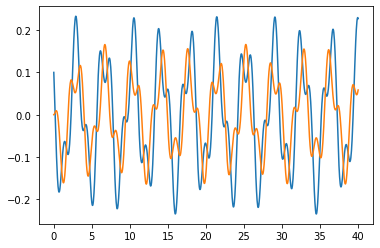

In [27]:
plt.plot(t,the2)
plt.plot(t,the1)
plt.show()

## Animando

Primero necesitamos una función que nos tome los ángulos y nos devuelva las ubicaciones en cartesianas de las dos masas.

In [28]:
def get_x1y1x2y2(t, the1, the2, L1, L2):
    return (L1*np.sin(the1),
           -L1*np.cos(the1),
           L1*np.sin(the1) + L2*np.sin(the2),
           -L1*np.cos(the1) - L2*np.cos(the2)
           )

x1, y1, x2, y2 = get_x1y1x2y2(t, the1, the2, L1, L2)

Ahora sí efectivamente animamos

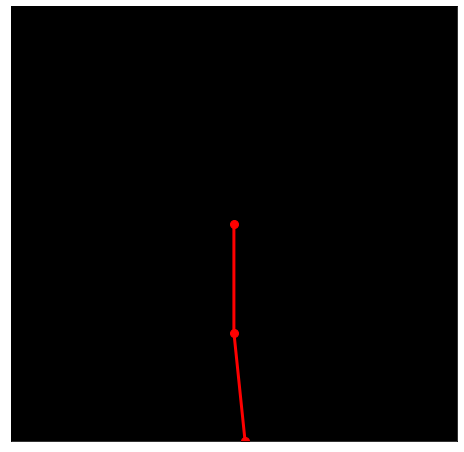

In [29]:
def animate(i):
    ln1.set_data([0, x1[i], x2[i]], [0, y1[i], y2[i]])
    return ln1
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.set_facecolor('k')
ax.get_xaxis().set_ticks([])    # Esto es para esconder los ticks del eje x
ax.get_yaxis().set_ticks([])    # Esto es para esconder los ticks del eje y
ln1, = plt.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], 'r-o', lw = 3, markersize = 8)
ax.set_ylim(-4,4)
ax.set_xlim(-4,4)
ani = animation.FuncAnimation(fig, animate, frames = 1000, interval = 50)
plt.show()
ani.save('pendulodoble.gif', writer = 'pillow', fps = 25)